In [1]:
%load_ext autoreload
%autoreload 2

label: 58445/0093943
offset: 0.2259999999946558
rv: 17.072721558875607
shk: 0.4191877544685568
label: 58638/167903
offset: 0.18299999999567262
rv: 13.824371881744408
shk: 0.3538212469644634
label: 58445/0143089
offset: 0.23299999999449028
rv: 17.601522669106267
shk: 0.434767390754669
label: 58497/8633602
offset: 0.13399999999683132
rv: 10.122764110129784
shk: 0.3330895822794221
label: 58497/8682518
offset: 0.13799999999673673
rv: 10.424936173118732
shk: 0.3291909278581351
label: 58638/1728067
offset: 0.10199999999758802
rv: 7.705387606218196
shk: 0.2816021717681481
closest for: 58372.8929264 is 10.892926400003489
label: 58372/8929264
offset: 0.16999999999598003
rv: 12.842312677030325
shk: 0.35304213408372803
closest for: 58372.8978241 is 10.897824100000435
label: 58372/8978241
offset: 0.16099999999619286
rv: 12.162425535305191
shk: 0.3482620968482603
label: 58394/8319412
offset: 0.20199999999522333
rv: 15.259689180941916
shk: 0.38252995620646524
label: 58394/8368211
offset: 0.203999999

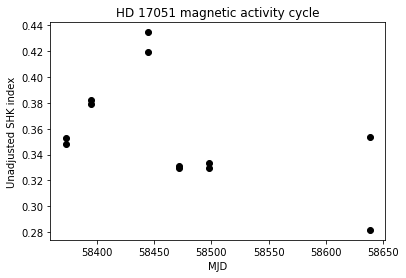

In [80]:
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk

from calc_del_lambda import import_lab_frame_spectra
from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


obsPath = '/home/agoga/Documents/nreshk/data/17051/obs/'
flatsPath = '/home/agoga/Documents/nreshk/data/17051/flats/'



obsDict = dict()
for obFile in os.listdir(obsPath):
    if obFile.endswith(".fits"):
        obsHDu1 = astropy.io.fits.open(obsPath+obFile)
        obsDate = mjd_from_hdu(obsHDu1)
        #print(obFile + ' for mjd: ' + str(obsDate))
        obsDict.update({obsDate:obsHDu1})
#        print(int(obsDate))
        
#print('-------------------------')

flatDict = dict()       
for flFile in os.listdir(flatsPath):
    if flFile.endswith(".fits"):
        flatHDu1 = astropy.io.fits.open(flatsPath+flFile)
        flatDate = mjd_from_hdu(flatHDu1)
        flatDict.update({int(flatDate):flatHDu1})
#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

res = .01
label =''

lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)



bad = [58330.3596906,58330.3634695,
       58553.7527935,58553.7479017,
       58272.4211262,58272.4248934,
       58354.2323109,58354.2381758]

   

tmpArray = [[],[]]

for oK in obsDict:
    if(oK in bad):
        continue
    fK = closestKey(flatDict,oK)
    
    if abs(oK-fK) > 2:
        print('closest for: '+str(oK) +' is '+ str(abs(oK-fK)))
    oHDu = obsDict[oK]
    fHDu = flatDict[fK]
    ret = mk_flatolap(oHDu[7].data, fHDu[0].data)
    lamGrid = ret[0]
    
    label=str(oK).replace('.','/') 
    
    print('label: ' + label)
    #plt.figure()
    #plt.title('mjd: ' + str(oK))
    
    targOlapf = calc_targOlapf(lamGrid,oHDu[7].data,oHDu[1].data, ret[1], label)
    #print('MJD: ' + str(oK))
    
    
    out = tmp_find_del_lam(lab[0],lab[1], lamGrid, targOlapf,res)
    dLam = out[0]
    
    lamda_zoom(lamGrid, out[2],lamGrid-out[0], out[1],[393.369,396.85,400.525,403.076,404.582,406.36], label ,.3)

    lamRef = 396.85
    #delta lamda / ref lamda * speed of light
    rv = dLam/ lamRef * sc.c 
    #rv from meters to km/s as desired by hk_windows
    rv = rv/10000
    print('rv: ' + str(rv))
    shk = calc_shk(lamGrid, targOlapf, rv)
    tmpArray[0].append(mjd_from_hdu(obsDict[oK]))
    tmpArray[1].append(shk)


    
    


    
shkArray = np.asarray(tmpArray)

plt.figure()    
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.title('HD 17051 magnetic activity cycle')
plt.xlabel('MJD')
plt.ylabel('Unadjusted SHK index')
plt.savefig('images/shk_time_series.pdf')
plt.show()
plt.close()

[2018.89317642 2019.42237782 2018.89318989 2019.03798181 2019.03799521
 2019.42239125 2018.69559706 2018.69561048 2018.75570395 2018.75571732
 2018.96746434 2018.96747777]


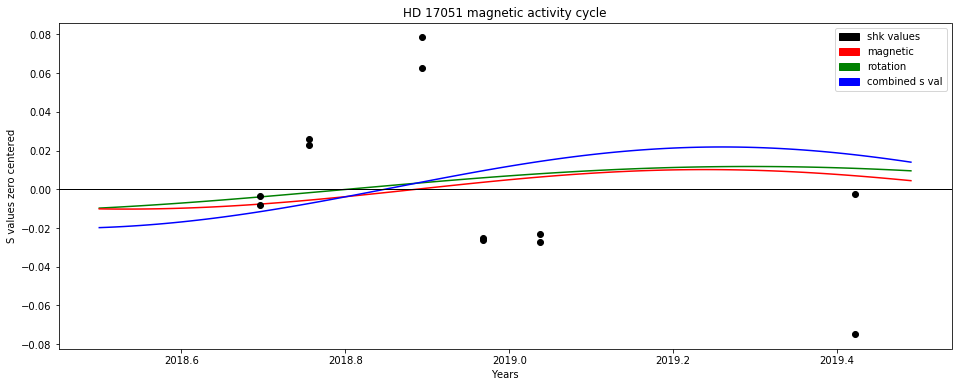

In [81]:
pi = sc.pi
p1 = 1.968
a1 = 0.0118
f1 = 6.27

p2 = 1.412
a2 = 0.0102
f2 = 4.51
sList = np.zeros((4,100))
for i in range(0,len(sList[0])):
    t = 2018.5 + (i/100)
    s1 = a1*np.sin(2*pi*(t+f1)/p1) 
    s2 = a2*np.sin(2*pi*(t+f2)/p2) 
    s = s1+s2
    sList[0,i]=t
    sList[1,i]=s1
    sList[2,i]=s2
    sList[3,i]=s
    
shkArray = np.asarray(tmpArray)


from astropy.time import Time
import matplotlib.patches as mpatches

plt.figure(figsize=(16,6))    
plt.plot(sList[0],sList[1],'g-')
plt.plot(sList[0],sList[2],'r-')
plt.plot(sList[0],sList[3],'b-')

    
t= Time(shkArray[0], format='mjd')
t.format = 'decimalyear'
print(t)
plt.plot(t.value,shkArray[1]-np.mean(shkArray[1]), 'ko')
plt.title('HD 17051 magnetic activity cycle')
plt.xlabel('Years')
plt.ylabel('S values zero centered')
plt.savefig('images/shk_time_series.pdf')
shkLeg = mpatches.Patch(color='black', label='shk values')
magLeg = mpatches.Patch(color='red', label='magnetic')
rotLeg = mpatches.Patch(color='green', label='rotation')
sLeg = mpatches.Patch(color='blue', label='combined s val')
plt.legend(handles=[shkLeg,magLeg,rotLeg,sLeg])
plt.axhline(linewidth=1, color='k')
plt.savefig('images/shk_adjusted_series.pdf')
plt.show()
plt.close()
